In [1]:

# Install required packages
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install nbformat plotly dash pandas numpy seaborn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install xgboost --break-system-package

Note: you may need to restart the kernel to use updated packages.


Index(['FlightDate', 'Reporting_Airline', 'OriginAirportSeqID', 'OriginState',
       'DepDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')


/var/folders/cr/rmz3xz_s61dd6zjh0mqy_z2m0000gn/T/ipykernel_55203/920970224.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FlightDate'] = pd.to_datetime(df['FlightDate'])


Random Forest MAE: 4.211178333193185, RMSE: 10.296798016271717
XGBoost MAE: 4.791396796956854, RMSE: 12.379932647251032


/Users/akshatsharma/CS506/CS506-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/akshatsharma/CS506/CS506-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


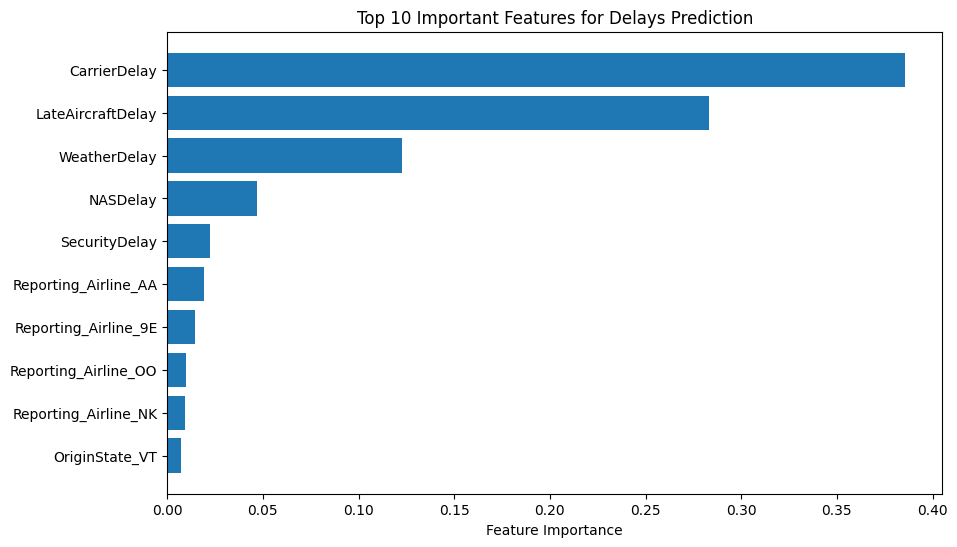

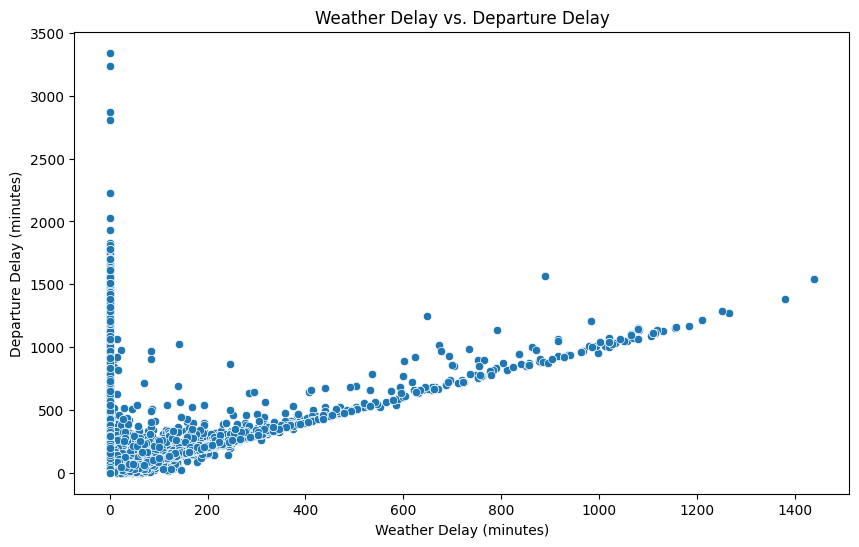

In [5]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load Data
all_files = glob.glob("data/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
print(df.columns)

# Step 2: Preprocessing
# Check which columns are actually present in the dataset
available_columns = df.columns.tolist()

# Fill missing delay columns with 0 (only for columns that exist)
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_columns:
    if col in available_columns:
        df[col] = df[col].fillna(0)

# Convert FlightDate to datetime and extract features (if FlightDate exists)
if 'FlightDate' in available_columns:
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['Day'] = df['FlightDate'].dt.day
    df['Month'] = df['FlightDate'].dt.month
    df['Year'] = df['FlightDate'].dt.year

# One-hot encoding for categorical features (only for columns that exist)
categorical_columns = ['Reporting_Airline', 'OriginState']
for col in categorical_columns:
    if col in available_columns:
        df = pd.get_dummies(df, columns=[col])

# Define the target variable and features
target_column = 'DepDelayMinutes'
if target_column not in available_columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset")

columns_to_drop = ['FlightDate', 'Cancelled', 'Diverted', 'CancellationCode']
X = df.drop(columns=[col for col in columns_to_drop if col in available_columns] + [target_column])
y = df[target_column]

# Remove any rows with NaN values in the target variable
mask = y.notna()
X = X[mask]
y = y[mask]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Training
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Step 5: Evaluation
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")
print(f"XGBoost MAE: {xgb_mae}, RMSE: {xgb_rmse}")

# Feature Importance for XGBoost
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features for Delays Prediction")
plt.show()

# Visualization
if 'WeatherDelay' in available_columns and target_column in available_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['WeatherDelay'], y=df[target_column])
    plt.xlabel('Weather Delay (minutes)')
    plt.ylabel('Departure Delay (minutes)')
    plt.title('Weather Delay vs. Departure Delay')
    plt.show()
else:
    print("Unable to create scatter plot: required columns not found in the dataset")

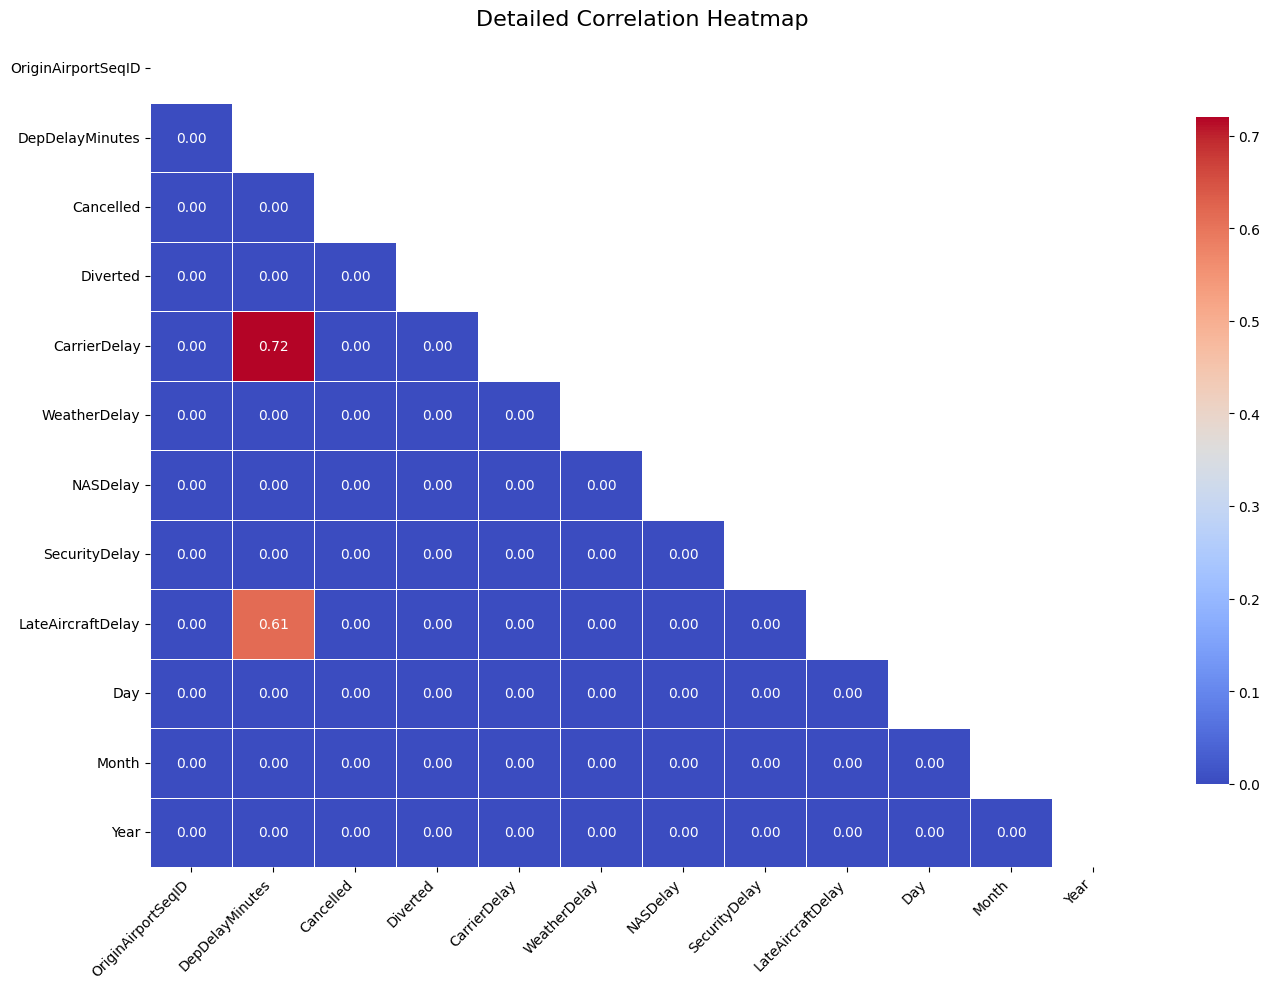

In [6]:
# Step 1: Select Numerical Features
numerical_cols = df.select_dtypes(include=np.number).columns

# Step 2: Sample Rows if Dataset is Large
sampled_df = df[numerical_cols]
if sampled_df.shape[0] > 10000:  # Limit to 10,000 rows
    sampled_df = sampled_df.sample(n=10000, random_state=42)

# Step 3: Compute Correlation Matrix
correlation_matrix = sampled_df.corr()

# Step 4: Focus on Highly Correlated Features
threshold = 0.5  # Only show correlations above or below this threshold
high_corr_features = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
filtered_corr_matrix = high_corr_features.fillna(0)

# Step 5: Create a Mask to Hide the Upper Triangle (Optional)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Step 6: Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    filtered_corr_matrix,
    mask=mask,  # Mask the upper triangle
    cmap='coolwarm',  # Diverging color palette
    annot=True,  # Show correlation values
    fmt=".2f",  # Format for the annotations
    linewidths=0.5,  # Add gridlines between cells
    cbar_kws={"shrink": 0.8},  # Shrink the color bar
)
plt.title("Detailed Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
import plotly.graph_objects as go

# Heatmap for Correlation Matrix
numerical_cols = df.select_dtypes(include=np.number).columns
sampled_df = df[numerical_cols].sample(n=10000, random_state=42)
correlation_matrix = sampled_df.corr()

fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale="Viridis",
        colorbar=dict(title="Correlation"),
    )
)
fig.update_layout(
    title="Interactive Correlation Heatmap",
    xaxis=dict(tickangle=45),
    yaxis=dict(autorange="reversed"),
    width=800,
    height=700,
)
fig.show()

In [8]:
import plotly.express as px

# Check if 'Month' and 'DepDelayMinutes' are available
if 'Month' in df and target_column in df:
    monthly_avg = df.groupby('Month')[target_column].mean().reset_index()
    fig = px.line(
        monthly_avg,
        x='Month',
        y=target_column,
        title='Average Departure Delay by Month',
        labels={'Month': 'Month', target_column: 'Avg Departure Delay (minutes)'},
    )
    fig.update_traces(line=dict(width=3))
    fig.update_layout(xaxis=dict(dtick=1))  # Ensure monthly ticks
    fig.show()
else:
    print("Unable to create time-series plot: required columns not found in the dataset")

In [9]:
# Feature Importance for XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    # Create a DataFrame for Plotly
    feature_data = pd.DataFrame({
        'Feature': [X.columns[i] for i in indices],
        'Importance': importances[indices]
    })

    # Interactive Bar Plot
    fig = px.bar(
        feature_data,
        x='Importance',
        y='Feature',
        orientation='h',
        title='Top 10 Important Features for Delays Prediction',
        labels={'Importance': 'Feature Importance'},
    )
    fig.update_traces(marker_color='blue', opacity=0.7)
    fig.show()
else:
    print("Feature importances are not available in the model.")

In [11]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Replace with your dataset and valid Plotly figures
fig1 = px.scatter(
    df,
    x='WeatherDelay',
    y='DepDelayMinutes',
    title='Weather Delay vs. Departure Delay',
    labels={'WeatherDelay': 'Weather Delay (minutes)', 'DepDelayMinutes': 'Departure Delay (minutes)'}
)

fig2 = px.line(
    df.groupby('Month')['DepDelayMinutes'].mean().reset_index(),
    x='Month',
    y='DepDelayMinutes',
    title='Average Departure Delay by Month',
    labels={'Month': 'Month', 'DepDelayMinutes': 'Avg Departure Delay (minutes)'}
)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Flight Delay Prediction Dashboard"),
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
])

if __name__ == "__main__":
    app.run_server(debug=True)